In [29]:
import pandas as pd

def read_data(file_dir):
    df = pd.read_csv(file_dir)
    return df

In [30]:
import matplotlib.pyplot as plt
import numpy

def visualize_data_aspect(df):
    exist = list()
    not_exist = list()
    
    one = 0
    zero = 0

    aspects = df.columns[:-1]
    X = numpy.arange(len(aspects))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    for col_name in aspects:
        for label in df[col_name]:
            if label == 'pos' or label == 'neg':
                one += 1
            else:
                zero += 1
                
        exist.append(one)
        not_exist.append(zero)
        one = 0
        zero = 0
        
    ax.bar(X + 0.00, exist, color = 'g', width = 0.25, label = 'exist')
    ax.bar(X + 0.25, not_exist, color = 'r', width = 0.25, label = 'not exist')
        
     
    plt.xticks(X, aspects)
    plt.xlabel("Aspek")
    plt.ylabel("Jumlah data")
    plt.title("Grafik data hasil pelabelan aspek")
    plt.legend()
    plt.show()
    
def visualize_data_sentimen(df):
    positive = list()
    negative = list()
    
    one = 0
    zero = 0

    aspects = df.columns[:-1]
    X = numpy.arange(len(aspects))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    for col_name in aspects:
        for label in df[col_name]:
            if label == 'pos':
                one += 1
            elif label == 'neg':
                zero += 1
    
        positive.append(one)
        negative.append(zero)
        one = 0
        zero = 0
        
    ax.bar(X + 0.00, positive, color = 'b', width = 0.25, label = 'positive')
    ax.bar(X + 0.25, negative, color = 'r', width = 0.25, label = 'negative')
     
    plt.xticks(X, aspects)
    plt.xlabel("Aspek")
    plt.ylabel("Jumlah data")
    plt.title("Grafik data hasil pelabelan sentimen")
    plt.legend()
    plt.show()

def visualize_data(df, col_name):
    one = 0
    zero = 0
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    for label in df[col_name]:
        if label == 1:
            one += 1
        else:
            zero += 1
    ax.bar(0.00, [one], color = 'g', width = 0.25)
    ax.bar(0.25, [zero], color = 'r', width = 0.25)

In [31]:
import string
from nltk import word_tokenize
import pickle

a_file = open("kamus.pkl", "rb")
kamus = pickle.load(a_file)

def words_normalization(sentence, dictionary):
    return " ".join([dictionary.get(w,w) for w in sentence.split()])

def preprocess1(text):
    case_folded = text.lower()
    exclude = set(string.punctuation + '1234567890')
    symbol_removed = ''.join(ch for ch in case_folded if ch not in exclude)
    word_normalized = words_normalization(symbol_removed, kamus)
    tokenized = word_tokenize(word_normalized)
    return tokenized

In [36]:
from nltk.tag import CRFTagger

def pos_tagging(data_ulasan):
    ct = CRFTagger()
    ct.set_model_file('all_indo_man_tag_corpus_model.crf.tagger')

    pos_ulasan = ct.tag_sents(data_ulasan)

    noun_data = list()
    for i,text in enumerate(pos_ulasan, start=0):
        temp = list()
        for term in text:
            if term[1] == 'VB' or term[1] == 'NN' or term[1] == 'JJ' or term[1] == 'RB':
                temp.append(term[0])
        noun_data.append(temp)

    pos_ulasan = data_ulasan

    for i in range(len(pos_ulasan)):
        pos_ulasan[i] = noun_data[i]
    
    return pos_ulasan

In [37]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

def preprocess2(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stop = set(stopwords.words('indonesian'))
    text = TreebankWordDetokenizer().detokenize(text)
    
    stop_removed = ' '.join([word for word in text.split() if word not in stop])
    stemmed = ' '.join([stemmer.stem(word) for word in stop_removed.split()])
    tokenized = word_tokenize(stemmed)
    return tokenized

In [38]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

def apply_oversampling(X, y):
    print('Original dataset shape %s' % Counter(y))
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

In [39]:
#Convert label to negative 0 or positive 1
import numpy

def convert_sentiment_label(df, col_name):
    index_nan = list()
    df2 = df[['Ulasan', col_name]].copy()
    df2[col_name].replace(str("pos"), 1, inplace=True)
    df2[col_name].replace(str("neg"), 0, inplace=True)
    df2[col_name].replace("", float("NaN"), inplace=True)
    df2.dropna(subset=[col_name], inplace=True)
    df2[col_name] = df2[col_name].astype(numpy.int64)
    
    return df2

def convert_aspect_label(df, col_name):
    index_nan = list()
    df2 = df[['Ulasan', col_name]].copy()
    df2[col_name].replace(float("NaN"), 0, inplace=True)
    df2[col_name].replace(str("pos"), 1, inplace=True)
    df2[col_name].replace(str("neg"), 1, inplace=True)
    df2[col_name] = df2[col_name].astype(numpy.int64)
    
    return df2

In [40]:
import sklearn
from sklearn.model_selection import train_test_split

def split_data(df, test_size):
    col_name = df.columns[1]
    words = df.Ulasan.tolist()
    label = df[col_name].tolist()
    x_train, x_test, y_train, y_test = train_test_split(words, label, test_size=test_size)
    return x_train, x_test, y_train, y_test

In [41]:
#https://stackoverflow.com/questions/53294482/how-to-get-tf-idf-scores-for-the-words

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorizer(x_train, x_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
    vecx_train = vectorizer.fit_transform(x_train).toarray()
    vecx_test = vectorizer.transform(x_test).toarray()
    return vecx_train, vecx_test, vectorizer

In [42]:
from sklearn.naive_bayes import MultinomialNB
from time import time

def train_data_nb(x_train, y_train):
    t0 = time()
    model = MultinomialNB()
    model.fit(x_train, y_train)
    print(f"\nTraining time: {round(time()-t0, 3)}s")
    t0 = time()
    return model

In [43]:
from sklearn import svm

def train_data_svm(x_train, y_train):
    t0 = time()
    model = svm.SVC(kernel='linear')
    model.fit(x_train, y_train)
    print(f"\nTraining time: {round(time()-t0, 3)}s")
    t0 = time()
    return model

In [44]:
def predict_data(text, model):
    data = [text]
    vec_data = vectorizer.transform(data).toarray()
    return model.predict(vec_data)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, vectorized_test_data, label):
    x_test = vectorized_test_data
    y_pred = model.predict(x_test)
    print(classification_report(label, y_pred))

In [46]:
from sklearn.model_selection import GridSearchCV

def grid_search_cv(X_train, y_train):
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10], 
                  'gamma': [1, 0.1, 0.01],
                  'kernel': ['linear']} 
  
    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
    # fitting the model for grid search
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)
    return grid

# Run Program!!!

In [56]:
df = read_data("Data skripsi/dataset_ulasan_full.csv")

In [57]:
df.head()

Learnability Efficiency Memorability Errors Satisfaction  \
0          pos        pos          pos    pos          pos   
1          pos        pos          pos    pos          pos   
2          NaN        pos          NaN    NaN          pos   
3          NaN        NaN          NaN    NaN          pos   
4          pos        pos          pos    NaN          pos   

                                              Ulasan  
0  Aplikasi ini sangat membantu saya saat pandemi...  
1                     Memesan perjalanan lebih mudah  
2  KAI smakin bagus pelayananya, krena situasi Pa...  
3                 Kedepannya lebih menyenangkan lagi  
4                          Sy banyak merasa terbantu

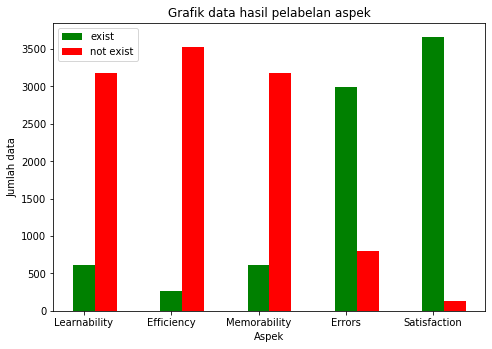

In [58]:
visualize_data_aspect(df)

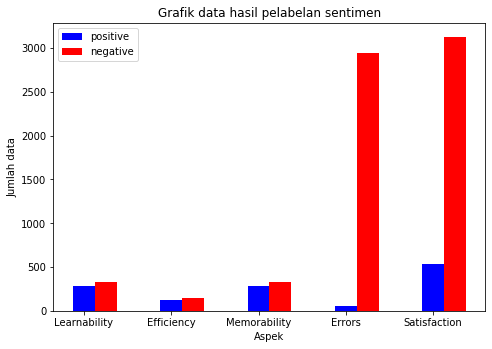

In [59]:
visualize_data_sentimen(df)

In [60]:
col_name1 = 'Learnability'
col_name2 = 'Efficiency'
col_name3 = 'Memorability'
col_name4 = 'Errors'
col_name5 = 'Satisfaction'

df_sentimen1 = convert_sentiment_label(df, col_name1)
df_aspect1 = convert_aspect_label(df, col_name1)

df_sentimen2 = convert_sentiment_label(df, col_name2)
df_aspect2 = convert_aspect_label(df, col_name2)

df_sentimen3 = convert_sentiment_label(df, col_name3)
df_aspect3 = convert_aspect_label(df, col_name3)

df_sentimen4 = convert_sentiment_label(df, col_name4)
df_aspect4 = convert_aspect_label(df, col_name4)

df_sentimen5 = convert_sentiment_label(df, col_name5)
df_aspect5 = convert_aspect_label(df, col_name5)

In [61]:
#Split Data 

x_train_a1, x_test_a1, y_train_a1, y_test_a1 = split_data(df_aspect1, test_size= 0.2)
x_train_s1, x_test_s1, y_train_s1, y_test_s1 = split_data(df_sentimen1, test_size= 0.2)

x_train_a2, x_test_a2, y_train_a2, y_test_a2 = split_data(df_aspect2, test_size= 0.2)
x_train_s2, x_test_s2, y_train_s2, y_test_s2 = split_data(df_sentimen2, test_size= 0.2)

x_train_a3, x_test_a3, y_train_a3, y_test_a3 = split_data(df_aspect3, test_size= 0.2)
x_train_s3, x_test_s3, y_train_s3, y_test_s3 = split_data(df_sentimen3, test_size= 0.2)

x_train_a4, x_test_a4, y_train_a4, y_test_a4 = split_data(df_aspect4, test_size= 0.2)
x_train_s4, x_test_s4, y_train_s4, y_test_s4 = split_data(df_sentimen4, test_size= 0.2)

x_train_a5, x_test_a5, y_train_a5, y_test_a5 = split_data(df_aspect5, test_size= 0.2)
x_train_s5, x_test_s5, y_train_s5, y_test_s5 = split_data(df_sentimen5, test_size= 0.2)

In [62]:
#Preprocessing 1

x_train_a1 = [preprocess1(text) for text in x_train_a1]
x_test_a1 = [preprocess1(text) for text in x_test_a1]

x_train_s1 = [preprocess1(text) for text in x_train_s1]
x_test_s1 = [preprocess1(text) for text in x_test_s1]

In [63]:
#Pos Tagging untuk data ulasan klasifikasi sentimen

x_train_s1 = pos_tagging(x_train_s1)
x_test_s1 = pos_tagging(x_test_s1)

In [64]:
#Preprocess 2

x_train_a1 = [preprocess2(text) for text in x_train_a1]
x_test_a1 = [preprocess2(text) for text in x_test_a1]

x_train_s1 = [preprocess2(text) for text in x_train_s1]
x_test_s1 = [preprocess2(text) for text in x_test_s1]

In [65]:
def detokenize(tokens):
    return TreebankWordDetokenizer().detokenize(tokens)

x_train_a1 = [detokenize(text) for text in x_train_a1]
x_test_a1 = [detokenize(text) for text in x_test_a1]

x_train_s1 = [detokenize(text) for text in x_train_s1]
x_test_s1 = [detokenize(text) for text in x_test_s1]

In [66]:
#Ekstraksi fitur TF-IDF

vx_train_a1, vx_test_a1, vectorizer_a1 = tfidf_vectorizer(x_train_a1, x_test_a1) #Untuk klasifikasi aspek
vx_train_s1, vx_test_s1, vectorizer_s1 = tfidf_vectorizer(x_train_s1, x_test_s1) #Untuk klasifikasi sentimen

In [67]:
#Oversampling

vx_train_a1, y_train_a1 = apply_oversampling(vx_train_a1, y_train_a1) #Oversampling data untuk klasifikasi aspek
print('----------------------------------------------------')
vx_train_s1, y_train_s1 = apply_oversampling(vx_train_s1, y_train_s1) ##Oversampling data untuk klasifikasi aspek

Original dataset shape Counter({0: 2531, 1: 502})
Resampled dataset shape Counter({0: 2531, 1: 2531})
----------------------------------------------------
Original dataset shape Counter({0: 262, 1: 231})
Resampled dataset shape Counter({1: 262, 0: 262})


# Multi-NB

In [70]:
#Model Training Multi-NB

model_nb_a1 = train_data_nb(vx_train_a1, y_train_a1) #Training Model klasifikasi aspek 
print('--------------------------------------------------------')
model_nb_s1 = train_data_nb(vx_train_s1, y_train_s1) #Training Model klasifikasi sentimen


Training time: 0.062s
--------------------------------------------------------

Training time: 0.014s


In [71]:
print(evaluate_model(model_nb_a1, vx_test_a1, y_test_a1))
print('-----------------------------------------')
print(evaluate_model(model_nb_s1, vx_test_s1, y_test_s1))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75       644
           1       0.17      0.40      0.24       115

    accuracy                           0.62       759
   macro avg       0.52      0.53      0.49       759
weighted avg       0.76      0.62      0.67       759

None
-----------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        69
           1       0.69      0.53      0.60        55

    accuracy                           0.69       124
   macro avg       0.69      0.67      0.67       124
weighted avg       0.69      0.69      0.68       124

None


# SVM

In [72]:
#Model Training SVM

model_svm_a1 = train_data_svm(vx_train_a1, y_train_a1) #Training Model klasifikasi aspek 
print('----------------------------------------------------------')
model_svm_s1 = train_data_svm(vx_train_s1, y_train_s1) #Training Model klasifikasi sentimen 



Training time: 52.48s
----------------------------------------------------------

Training time: 0.251s


In [74]:
print(evaluate_model(model_svm_a1, vx_test_a1, y_test_a1))
print('-----------------------------------------')
print(evaluate_model(model_svm_s1, vx_test_s1, y_test_s1))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       644
           1       0.17      0.37      0.23       115

    accuracy                           0.63       759
   macro avg       0.51      0.52      0.49       759
weighted avg       0.75      0.63      0.68       759

None
-----------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        69
           1       0.65      0.51      0.57        55

    accuracy                           0.66       124
   macro avg       0.66      0.65      0.65       124
weighted avg       0.66      0.66      0.65       124

None


# SVM with GridSearchCV

In [68]:
#Model Training SVM dengan GridSearchCV

grid_svm1 = grid_search_cv(vx_train1, y_train1) #Untuk Model klasifikasi aspek 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.624 total time=  55.5s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.673 total time=  56.8s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.704 total time=  57.6s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.717 total time=  58.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.702 total time=  55.9s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.624 total time=  55.5s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.673 total time=  57.0s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.704 total time=  56.9s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.717 total time=  56.7s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.702 total time=  57.1s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.624 total time=  56.1s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;,

In [ ]:
#grid_svm2 = grid_search_cv(vx_train2, y_train2) #Untuk Model klasifikasi sentimen 

In [69]:
print(evaluate_model(grid_svm1, vx_test1, y_test1))

              precision    recall  f1-score   support

           0       0.27      0.33      0.29       145
           1       0.83      0.78      0.81       614

    accuracy                           0.70       759
   macro avg       0.55      0.56      0.55       759
weighted avg       0.72      0.70      0.71       759

None


In [19]:
#SOurce: https://towardsdatascience.com/training-a-naive-bayes-model-to-identify-the-author-of-an-email-or-document-17dc85fa630a